# Step 1: Setup and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ta

In [2]:
import os
import ta

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

['data', 'utils', 'src', 'models_results', 'notebooks']


'/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [3]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns

from src.forecasting.TransformerForecaster import TransformerForecaster
from src.pattern_recognition.CNNRecogniser import ChartPatternCNN
from src.backtesting.backtester import Backtester

# Step 2: Exploratory Data Analysis
Findings:
1. We do not have Volume data.

In [4]:
data_base = f"{os.environ['GOOGLE_DRIVE_PATH']}/data"
data = pd.read_csv(f"{data_base}/NIFTY 50_minute_data.csv", parse_dates=['date'])

In [5]:
data.head()

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0


In [6]:
data['date'].iloc[0]

Timestamp('2015-01-09 09:15:00')

In [7]:
data.isna().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0


In [8]:
zero_volume_count = len(data[data['volume'] == 0])
print(f"Number of rows with zero volume: {zero_volume_count}")


Number of rows with zero volume: 932946


In [9]:
data.shape

(932946, 6)

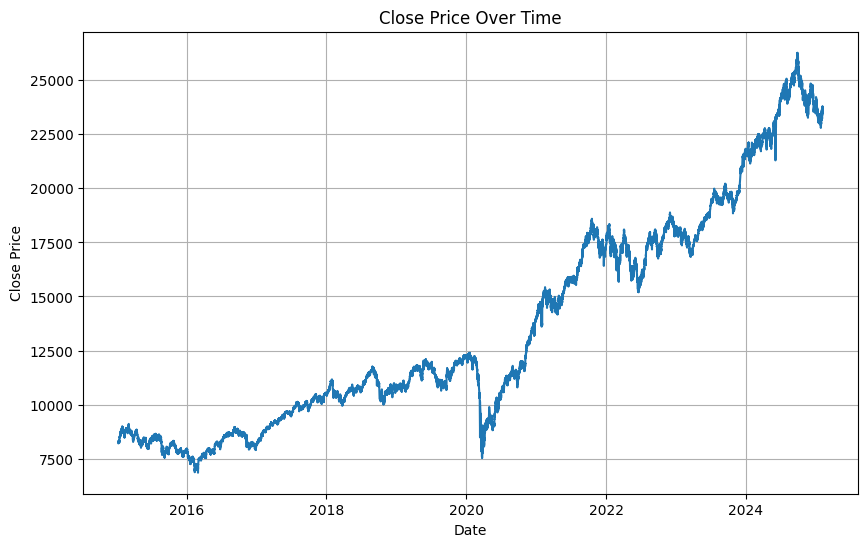

In [10]:
# prompt: create a plot with 'close' column in y-axis and date in x-axis

import matplotlib.pyplot as plt

# Assuming 'data' DataFrame is already loaded as in your provided code
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')
plt.grid(True)
plt.show()


In [11]:
# prompt: create a function which takes window size, shift window and column name and dataframe as input to add another column in the dataframe with dma over the window size

def add_dma_column(df, window_size, shift_window, column_name):
    """
    Calculates the Double Moving Average (DMA) and adds it as a new column to the DataFrame.

    Args:
        df: The input DataFrame.
        window_size: The window size for the moving average.
        shift_window: The shift for the second moving average.
        column_name: The name of the column to calculate DMA on.

    Returns:
        A new DataFrame with the added DMA column.  Returns the original DataFrame if
        there's an error (e.g., column not found).
    """
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return df  # Return original DataFrame if column doesn't exist

    try:
        # Calculate the first moving average
        dma_1 = df[column_name].rolling(window=window_size).mean()

        # Calculate the second moving average (shifted)
        dma_2 = dma_1.shift(shift_window)

        # Calculate DMA
        # dma = dma_1 - dma_2

        # Add the DMA as a new column to the DataFrame
        df[f'DMA_{column_name}_{window_size}_{shift_window}'] = dma_2
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return df # Return original DataFrame in case of error


In [12]:
# # prompt: create a function which takes window size and column name and dataframe as input to add another column in the dataframe with dma over the window size

# def add_dma_column(df, window_size, column_name, dma_shift_window):
#   """
#   Calculates the Double Moving Average (DMA) over a specified window size for a given column in a DataFrame.

#   Args:
#       df: The input DataFrame.
#       window_size: The size of the rolling window for the DMA calculation.
#       column_name: The name of the column to calculate the DMA for.

#   Returns:
#       A new DataFrame with an additional column containing the DMA values.
#       Returns the original DataFrame if the column_name is not found.
#   """

#   if column_name not in df.columns:
#     print(f"Error: Column '{column_name}' not found in DataFrame.")
#     return df

#   # Calculate the first moving average
#   df['MA1'] = df[column_name].rolling(window=window_size).mean()

#   # Calculate the second moving average (DMA)
#   df[f'DMA_{window_size}'] = df['MA1'].rolling(window=window_size).mean()

#   # Drop the temporary 'MA1' column
#   df = df.drop('MA1', axis=1)

#   return df


In [13]:
# prompt: create a function which takes window size and column name and dataframe as input to add another column in the dataframe with ema over the window size

def add_ema_column(df, window_size, column_name):
  """
  Calculates the Exponential Moving Average (EMA) over a specified window size for a given column in a DataFrame.

  Args:
      df: The input DataFrame.
      window_size: The size of the rolling window for the EMA calculation.
      column_name: The name of the column to calculate the EMA for.

  Returns:
      A new DataFrame with an additional column containing the EMA values.
      Returns the original DataFrame if the column_name is not found or if an error occurs during calculation.
  """
  if column_name not in df.columns:
    print(f"Error: Column '{column_name}' not found in DataFrame.")
    return df

  try:
    # Calculate the EMA
    df[f'EMA_{window_size}'] = df[column_name].ewm(span=window_size, adjust=False).mean()
    return df
  except Exception as e:
    print(f"An error occurred during EMA calculation: {e}")
    return df


In [17]:
dma_window_size =5000
ema_window_size = 5000
dma_shift_window = 1000

In [15]:
data = add_dma_column(data, dma_window_size, dma_shift_window, 'close')
data = add_ema_column(data, ema_window_size, 'close')

In [16]:
data.head(20)

,date,open,high,low,close,volume,DMA_close_5000_1000,EMA_5000
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0,NaN,8292.100000
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0,NaN,8292.098420
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0,NaN,8292.099141
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0,NaN,8292.102560
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0,NaN,8292.106199
5,2015-01-09 09:20:00,8300.50,8303.00,8298.60,8300.00,0,NaN,8292.109356
6,2015-01-09 09:21:00,8300.65,8302.90,8300.00,8301.85,0,NaN,8292.113251
7,2015-01-09 09:22:00,8302.45,8302.45,8295.00,8295.00,0,NaN,8292.114406
8,2015-01-09 09:23:00,8294.85,8295.35,8293.25,8294.70,0,NaN,8292.115440
9,2015-01-09 09:24:00,8295.20,8302.55,8294.70,8301.00,0,NaN,8292.118993


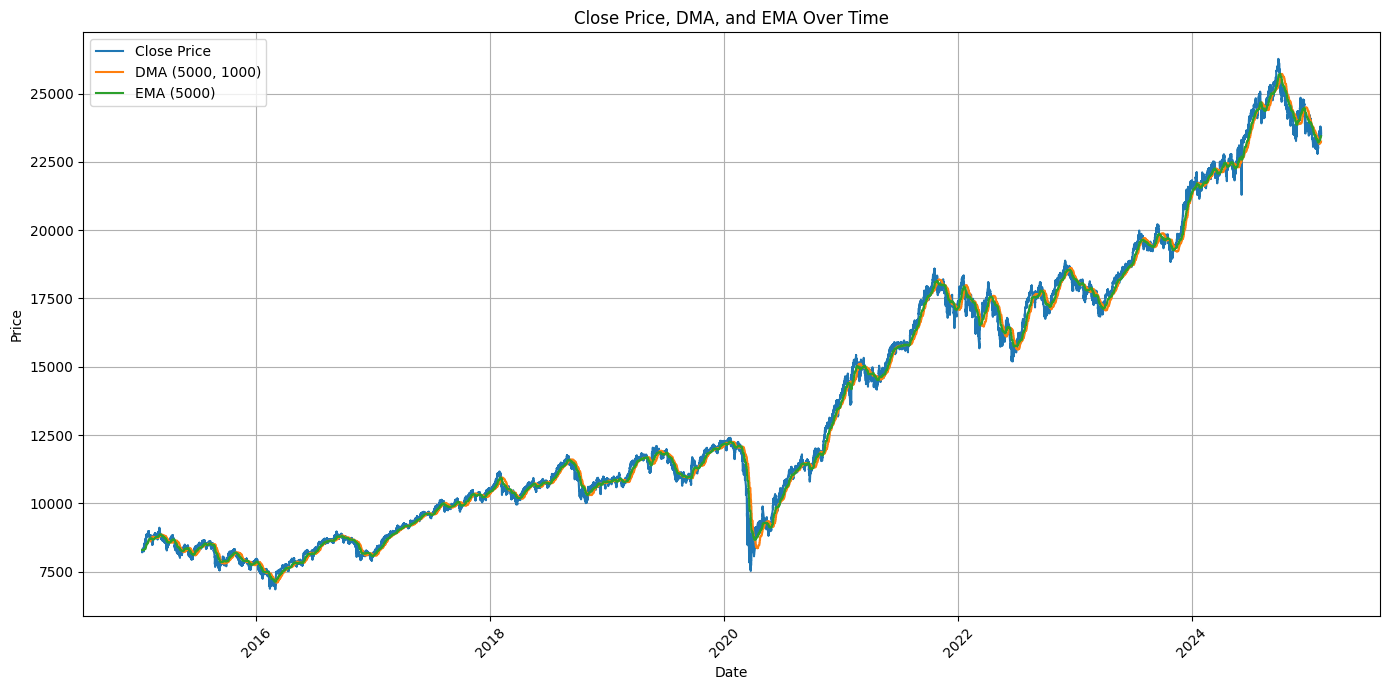

In [19]:
# prompt: generate a plot with close, dma and ema in y-axis and date in x-axis

import matplotlib.pyplot as plt

# Assuming 'data' DataFrame is already loaded and processed as in the previous code

plt.figure(figsize=(14, 7))  # Adjust figure size for better visualization

plt.plot(data['date'], data['close'], label='Close Price')
plt.plot(data['date'], data[f'DMA_close_{dma_window_size}_{dma_shift_window}'], label=f'DMA ({dma_window_size}, {dma_shift_window})')
plt.plot(data['date'], data[f'EMA_{ema_window_size}'], label=f'EMA ({ema_window_size})')


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price, DMA, and EMA Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability if needed
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [21]:
# prompt: function to create bollinger bands for the close price

def add_bollinger_bands(df, window_size, num_std_dev, column_name='close'):
    """
    Calculates Bollinger Bands for a given column in a DataFrame.

    Args:
        df: The input DataFrame.
        window_size: The size of the rolling window for the Bollinger Bands calculation.
        num_std_dev: The number of standard deviations to use for the upper and lower bands.
        column_name: The name of the column to calculate the Bollinger Bands for.

    Returns:
        A new DataFrame with additional columns for the middle band, upper band, and lower band.
        Returns the original DataFrame if the column_name is not found or if an error occurs.
    """

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return df

    try:
        # Calculate the rolling mean (middle band)
        df[f'BB_Middle_{window_size}'] = df[column_name].rolling(window=window_size).mean()

        # Calculate the rolling standard deviation
        df[f'BB_StdDev_{window_size}'] = df[column_name].rolling(window=window_size).std()

        # Calculate the upper and lower bands
        df[f'BB_Upper_{window_size}'] = df[f'BB_Middle_{window_size}'] + num_std_dev * df[f'BB_StdDev_{window_size}']
        df[f'BB_Lower_{window_size}'] = df[f'BB_Middle_{window_size}'] - num_std_dev * df[f'BB_StdDev_{window_size}']

        return df
    except Exception as e:
        print(f"An error occurred during Bollinger Band calculation: {e}")
        return df


In [22]:
bb_window_size = 1000
bb_std_dev = 5

data = add_bollinger_bands(data, bb_window_size, bb_std_dev)

<ipython-input-23-628bf194f95a>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


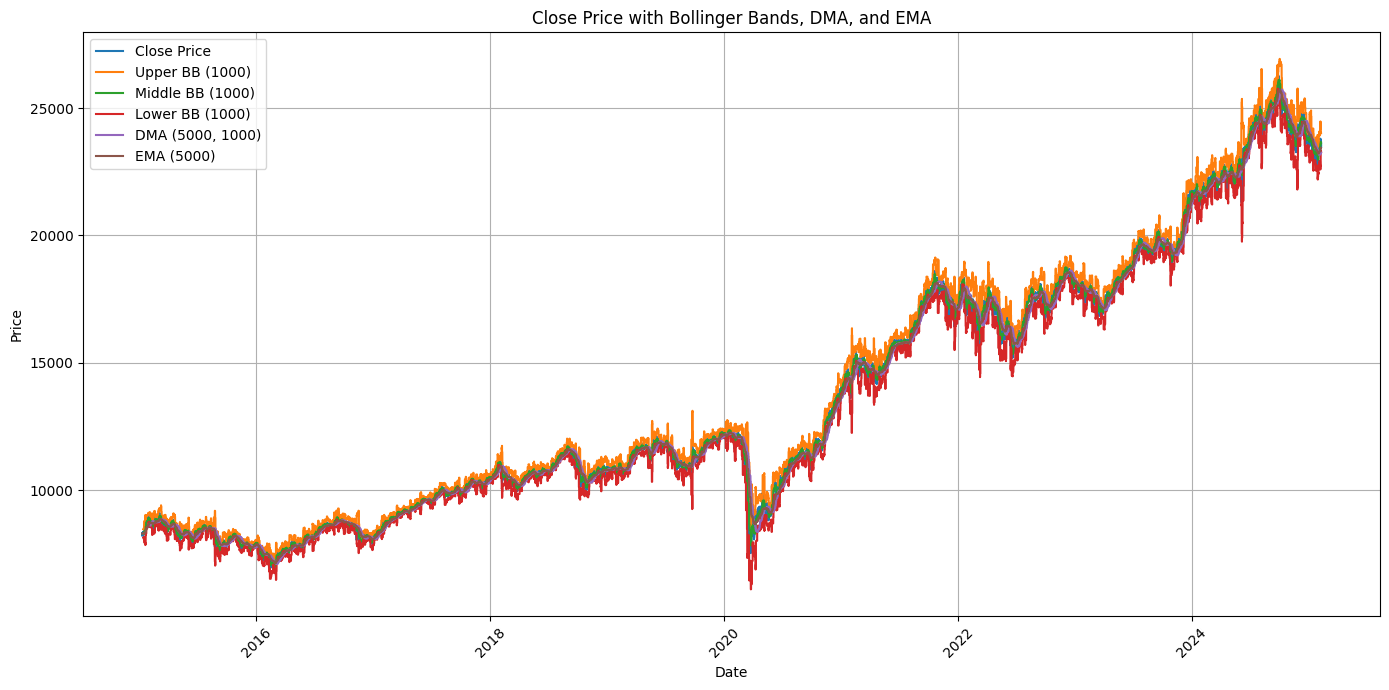

In [23]:
# prompt: plot close price with bollinger bands and dma and ema

import matplotlib.pyplot as plt
# Assuming 'data' DataFrame is already loaded and processed as in the previous code

plt.figure(figsize=(14, 7))  # Adjust figure size for better visualization

plt.plot(data['date'], data['close'], label='Close Price')
plt.plot(data['date'], data[f'BB_Upper_{bb_window_size}'], label=f'Upper BB ({bb_window_size})')
plt.plot(data['date'], data[f'BB_Middle_{bb_window_size}'], label=f'Middle BB ({bb_window_size})')
plt.plot(data['date'], data[f'BB_Lower_{bb_window_size}'], label=f'Lower BB ({bb_window_size})')
plt.plot(data['date'], data[f'DMA_close_{dma_window_size}_{dma_shift_window}'], label=f'DMA ({dma_window_size}, {dma_shift_window})')
plt.plot(data['date'], data[f'EMA_{ema_window_size}'], label=f'EMA ({ema_window_size})')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price with Bollinger Bands, DMA, and EMA')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability if needed
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [24]:
print("Basic Statistics:")
print(data[['date', 'open', 'high', 'low', 'close', 'volume']].describe())

Basic Statistics:
                                date           open           high  \
count                         932946  932946.000000  932946.000000   
mean   2020-01-27 17:32:11.946240512   13623.775737   13626.579175   
min              2015-01-09 09:15:00    6846.800000    6860.900000   
25%              2017-07-19 15:17:15    9428.450000    9431.062500   
50%              2020-01-30 12:22:30   11561.450000   11563.850000   
75%              2022-08-03 09:23:45   17607.137500   17610.500000   
max              2025-02-07 15:29:00   26273.400000   26277.350000   
std                              NaN    5047.819576    5048.732529   

                 low          close    volume  
count  932946.000000  932946.000000  932946.0  
mean    13620.939753   13623.752285       0.0  
min      6826.350000    6848.100000       0.0  
25%      9426.162500    9428.650000       0.0  
50%     11559.275000   11561.450000       0.0  
75%     17603.450000   17607.150000       0.0  
max     26270.6

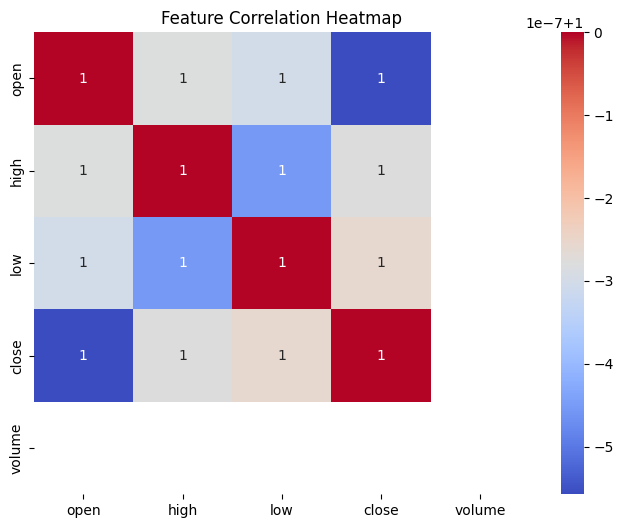

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

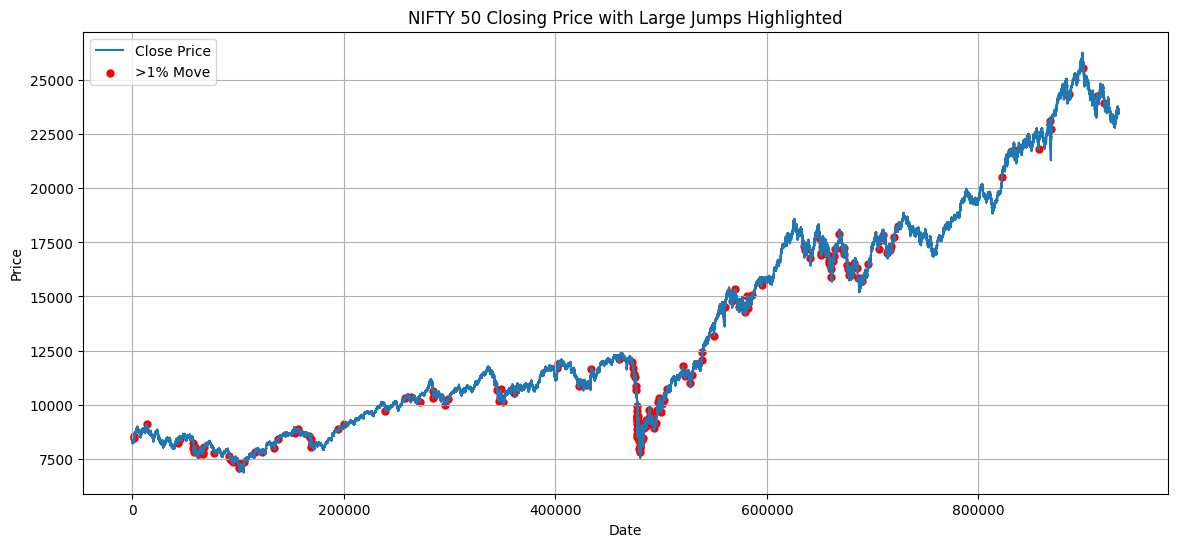


Number of large price moves (>1%): 188


In [ ]:
data['returns'] = data['close'].pct_change()
large_jumps = data[data['returns'].abs() > 0.01]

plt.figure(figsize=(14, 6))
plt.plot(data['close'], label='Close Price')
plt.scatter(large_jumps.index, large_jumps['close'], color='red', label='>1% Move', s=25)
plt.title('NIFTY 50 Closing Price with Large Jumps Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print("\nNumber of large price moves (>1%):", len(large_jumps))

In [ ]:
def plot_one_day_data(df, date_str):
  date_obj = pd.to_datetime(date_str)

  one_day_data = df[df['date'].dt.date == date_obj.date()]

  if one_day_data.empty:
      print(f"No data found for {date_str}")
      return

  plt.figure(figsize=(14, 7))
  plt.plot(one_day_data['date'], one_day_data['close'], label='Close Price')

  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.title(f'NIFTY 50 Data for {date_str}')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [33]:
# import ta-lib
# ta-lib has some install issues.

In [34]:
import ta

In [35]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'DMA_close_5000_1000',
       'EMA_5000', 'BB_Middle_1000', 'BB_StdDev_1000', 'BB_Upper_1000',
       'BB_Lower_1000'],
      dtype='object')

In [37]:
data['atr'] = ta.volatility.AverageTrueRange(high=data['high'], low=data['low'], close=data['close'], window=14).average_true_range()

In [38]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'DMA_close_5000_1000',
       'EMA_5000', 'BB_Middle_1000', 'BB_StdDev_1000', 'BB_Upper_1000',
       'BB_Lower_1000', 'atr'],
      dtype='object')